# GENIE3: Description & Implementation

#### Modules Importation

In [73]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from numpy import *
import time
from operator import itemgetter
from multiprocessing import Pool
import igraph
import os 
import re

In [4]:
def compute_feature_importances(estimator):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = asarray(importances)
        return sum(importances,axis=0) / len(estimator)

In [5]:
def get_link_list(VIM,gene_names=None,regulators='all',maxcount='all',file_name=None):
    
    """Gets the ranked list of (directed) regulatory links.
    
    Parameters
    ----------
    
    VIM: numpy array
        Array as returned by the function GENIE3(), in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. 
        
    gene_names: list of strings, optional
        List of length p, where p is the number of rows/columns in VIM, containing the names of the genes. The i-th item of gene_names must correspond to the i-th row/column of VIM. When the gene names are not provided, the i-th gene is named Gi.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names), and the returned list contains only edges directed from the candidate regulators. When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    maxcount: 'all' or positive integer, optional
        Writes only the first maxcount regulatory links of the ranked list. When maxcount is set to 'all', all the regulatory links are written.
        default: 'all'
        
    file_name: string, optional
        Writes the ranked list of regulatory links to the file file_name.
        default: None
        
        
    
    Returns
    -------
    
    The list of regulatory links, ordered according to the edge score. Auto-regulations do not appear in the list. Regulatory links with a score equal to zero are randomly permuted. In the ranked list of edges, each line has format:
        
        regulator   target gene     score of edge
    """
    
    # Check input arguments      
    if not isinstance(VIM,ndarray):
        raise ValueError('VIM must be a square array')
    elif VIM.shape[0] != VIM.shape[1]:
        raise ValueError('VIM must be a square array')
        
    ngenes = VIM.shape[0]
        
    if gene_names != None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expression data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('The genes must contain at least one candidate regulator')
        
    if maxcount != 'all' and not isinstance(maxcount,int):
        raise ValueError('input argument maxcount must be "all" or a positive integer')
        
    if file_name != None and not isinstance(file_name,str):
        raise ValueError('input argument file_name must be a string')
    
    

    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = range(ngenes)
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]
    
    # Get the non-ranked list of regulatory links
    vInter = [(i,j,score) for (i,j),score in ndenumerate(VIM) if i in input_idx and i!=j]
    
    # Rank the list according to the weights of the edges        
    vInter_sort = sorted(vInter,key=itemgetter(2),reverse=True)
    nInter = len(vInter_sort)
    
    # Random permutation of edges with score equal to 0
    flag = 1
    i = 0
    while flag and i < nInter:
        (TF_idx,target_idx,score) = vInter_sort[i]
        if score == 0:
            flag = 0
        else:
            i += 1
            
    if not flag:
        items_perm = vInter_sort[i:]
        items_perm = random.permutation(items_perm)
        vInter_sort[i:] = items_perm
        
    # Write the ranked list of edges
    nToWrite = nInter
    if isinstance(maxcount,int) and maxcount >= 0 and maxcount < nInter:
        nToWrite = maxcount
        
    if file_name:
    
        outfile = open(file_name,'w')
    
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('%s\t%s\t%.6f\n' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('G%d\tG%d\t%.6f\n' % (TF_idx+1,target_idx+1,score))
            
        
        outfile.close()
        
    else:
        
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('%s\t%s\t%.6f' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('G%d\tG%d\t%.6f' % (TF_idx+1,target_idx+1,score))

In [6]:
def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------

    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
        
        
    print('Tree method: ' + str(tree_method))
    print('K: ' + str(K))
    print('Number of trees: ' + str(ntrees))
    print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        print('running single threaded jobs')
        for i in range(ngenes):
            print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM

In [7]:
def wr_GENIE3_single(args):
    return([args[1], GENIE3_single(args[0], args[1], args[2], args[3], args[4], args[5])])

In [8]:
def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features)

    # Learn ensemble of trees
    treeEstimator.fit(expr_data_input,output)
    
    # Compute importance scores
    feature_importances = compute_feature_importances(treeEstimator)
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi

In [115]:
def GetFilePaths(rootPath):
    filesList=[]
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            if file.endswith(".tsv") and not file.endswith("indexes.tsv"):
                filesList.append(os.path.join(root, file))
    return filesList

def WriteValues(rootPath):
    
    fluxWriteSteady=open(rootPath+'steadyState.tsv','w')
    flagHeaderSteady=0
    regexHeaderSteady=".*G.*"
    
    fluxWriteTime=open(rootPath+'timeSeries.tsv','w')
    
    files=GetFilePaths(rootPath)
    
    
    for file in files:
        
        fluxRead=open(file,'r')
        lines=fluxRead.readlines()
        
        
        if file.endswith("timeseries.tsv"):
            for line in lines:
                fluxWriteTime.write(line)        
            
        else :
            
            if lines and flagHeaderSteady==0:
                if(re.match(regexHeaderSteady,lines[0])):
                    flagHeaderSteady=1
                    fluxWriteSteady.write(re.match(regexHeaderSteady,lines[0]).group(0)+'\n')
                    
            if flagHeaderSteady==1:
                lines=lines[1:]
            for line in lines:
                fluxWriteSteady.write(line)
                
        fluxRead.close()
        
    fluxWriteSteady.close()
    fluxWriteTime.close()
    
            

        
WriteValues('../DREAM_DATA/training_data/InSilico_10/')

In [100]:

f = open('../DREAM_DATA/training_data/InSilico_10/steadyState.tsv')
data=loadtxt('../DREAM_DATA/training_data/InSilico_10/steadyState.tsv',skiprows=1)
gene_names = f.readline()
f.close()
gene_names = gene_names.rstrip('\n').split('\t')

VIM=GENIE3(data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1)

Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/10...
Gene 2/10...
Gene 3/10...
Gene 4/10...
Gene 5/10...
Gene 6/10...
Gene 7/10...
Gene 8/10...
Gene 9/10...
Gene 10/10...
Elapsed time: 12.08 seconds


In [118]:
conn_indices = where(VIM) 
weights = VIM[conn_indices]
edges = zip(*conn_indices)
g=igraph.Graph(directed=True,edges=edges)
g.es['weight']=VIM
g.es["width"]=weights * 4
#g.es["label"]=VIM
g.vs['label']=gene_names

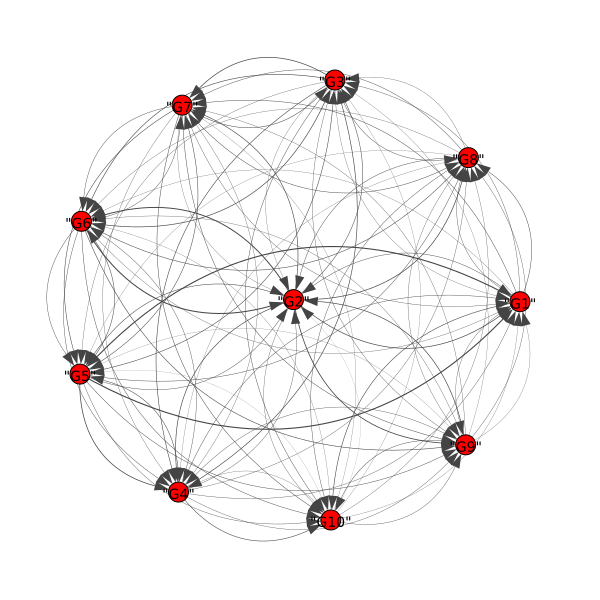

In [119]:
igraph.plot(g,labels=True,margin=80)
#g.get_edgelist()

In [114]:
VIM

array([[0.        , 0.10874501, 0.09397871, 0.10570087, 0.27399095,
        0.06349665, 0.11426182, 0.11648746, 0.08307369, 0.14380914],
       [0.16782997, 0.        , 0.12628745, 0.15827791, 0.1308806 ,
        0.23721767, 0.15407046, 0.17062593, 0.19879129, 0.08283649],
       [0.07131554, 0.06583261, 0.        , 0.14457886, 0.07809787,
        0.1477345 , 0.17360348, 0.10434463, 0.08806673, 0.1084985 ],
       [0.09127755, 0.09237422, 0.15780055, 0.        , 0.12776139,
        0.09847635, 0.07761875, 0.08635921, 0.08768319, 0.13824616],
       [0.27565827, 0.1057685 , 0.13533907, 0.18492395, 0.        ,
        0.12656824, 0.1280268 , 0.10920841, 0.11006668, 0.09299485],
       [0.07993574, 0.25426639, 0.16203327, 0.1044753 , 0.10478073,
        0.        , 0.10176819, 0.13015312, 0.14005716, 0.11129895],
       [0.08981181, 0.06842481, 0.12484076, 0.07681982, 0.13380212,
        0.10448424, 0.        , 0.11460342, 0.11463488, 0.1198766 ],
       [0.09254588, 0.10833886, 0.0752509